In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torchvision import models
import pandas as pd





In [12]:
# Define transformations (normalization and augmentation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = r'UCMerced_LandUse/Images' 
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Class names
class_names = dataset.classes
num_classes = len(class_names)

print(f"Dataset Loaded: {len(dataset)} images across {num_classes} classes.")



Dataset Loaded: 2100 images across 21 classes.


Epoch 1/10 - Train Loss: 2.0777, Train Acc: 56.55% | Test Loss: 5.0821, Test Acc: 50.48%
Epoch 2/10 - Train Loss: 0.6424, Train Acc: 81.01% | Test Loss: 0.7655, Test Acc: 80.48%
Epoch 3/10 - Train Loss: 0.4327, Train Acc: 87.14% | Test Loss: 0.7852, Test Acc: 83.81%
Epoch 4/10 - Train Loss: 0.3980, Train Acc: 89.46% | Test Loss: 2.8224, Test Acc: 70.24%
Epoch 5/10 - Train Loss: 0.3081, Train Acc: 91.01% | Test Loss: 0.4157, Test Acc: 88.57%
Epoch 6/10 - Train Loss: 0.3130, Train Acc: 92.08% | Test Loss: 0.4717, Test Acc: 87.62%
Epoch 7/10 - Train Loss: 0.2152, Train Acc: 92.74% | Test Loss: 0.3720, Test Acc: 89.05%
Epoch 8/10 - Train Loss: 0.1342, Train Acc: 96.43% | Test Loss: 0.3501, Test Acc: 91.67%
Epoch 9/10 - Train Loss: 0.1505, Train Acc: 95.18% | Test Loss: 0.8290, Test Acc: 85.48%
Epoch 10/10 - Train Loss: 0.1264, Train Acc: 96.13% | Test Loss: 0.3059, Test Acc: 92.62%


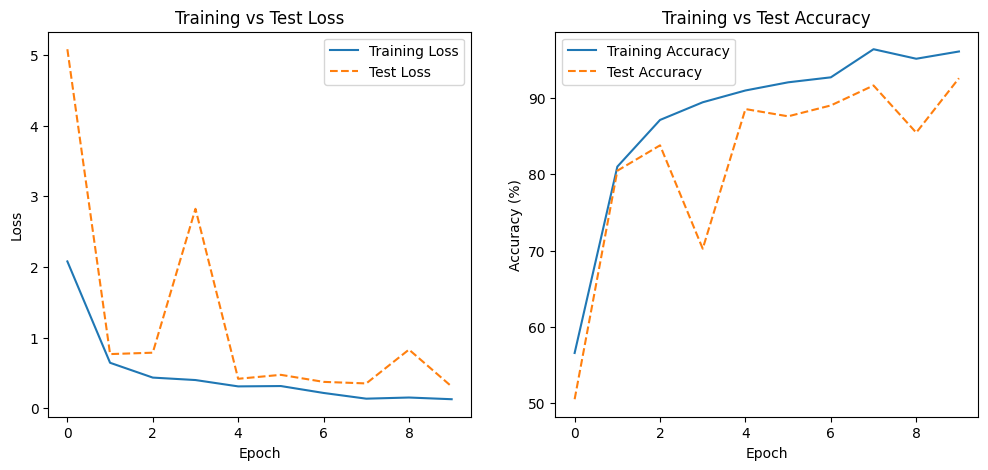

In [15]:


# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50 and modify for classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 without pre-trained weights
model = models.resnet50(pretrained=False)

# Load the pre-trained weights from the downloaded file
model.load_state_dict(torch.load('resnet50-19c8e357.pth', map_location=device, weights_only= False))

# Move the model to the desired device (GPU/CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Compute average training loss and accuracy
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        # Compute average test loss and accuracy
        epoch_test_loss = running_test_loss / len(test_loader)
        epoch_test_acc = 100 * correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies


train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10
)

# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training vs Test Accuracy')

plt.show()



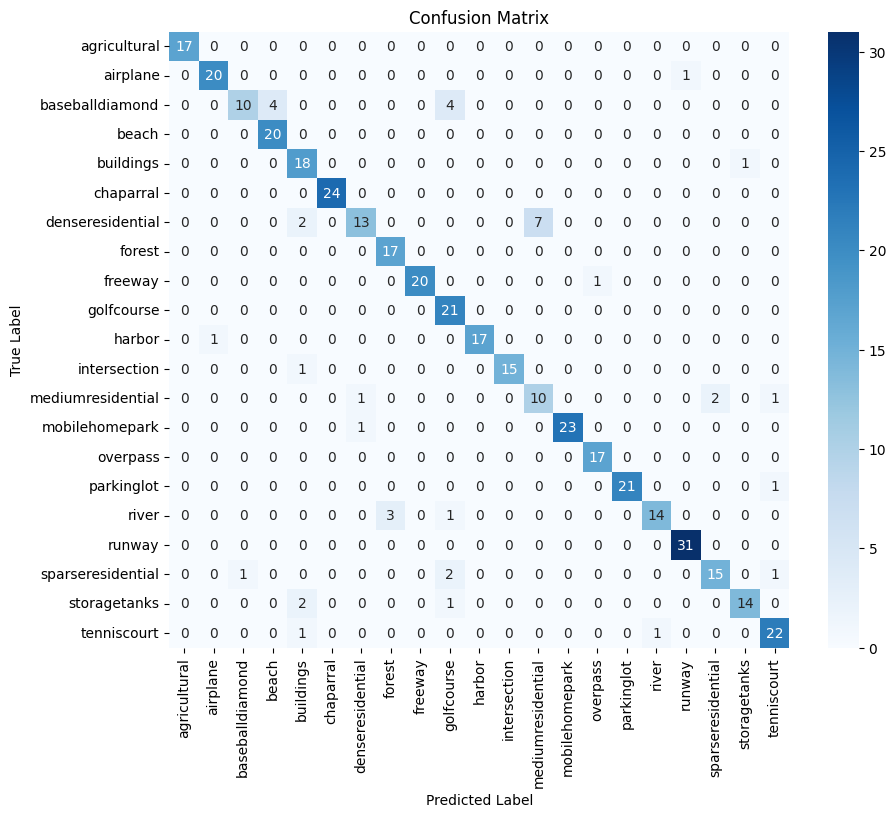

                   precision    recall  f1-score     support
agricultural        1.000000  1.000000  1.000000   17.000000
airplane            0.952381  0.952381  0.952381   21.000000
baseballdiamond     0.909091  0.555556  0.689655   18.000000
beach               0.833333  1.000000  0.909091   20.000000
buildings           0.750000  0.947368  0.837209   19.000000
chaparral           1.000000  1.000000  1.000000   24.000000
denseresidential    0.866667  0.590909  0.702703   22.000000
forest              0.850000  1.000000  0.918919   17.000000
freeway             1.000000  0.952381  0.975610   21.000000
golfcourse          0.724138  1.000000  0.840000   21.000000
harbor              1.000000  0.944444  0.971429   18.000000
intersection        1.000000  0.937500  0.967742   16.000000
mediumresidential   0.588235  0.714286  0.645161   14.000000
mobilehomepark      1.000000  0.958333  0.978723   24.000000
overpass            0.944444  1.000000  0.971429   17.000000
parkinglot          1.00

In [16]:
# Function to evaluate the model and generate reports
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Convert classification report to DataFrame
    df_report = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return df_report

# Call the function
df_results = evaluate_model_with_metrics(model, test_loader, class_names)

# Display results table
print(df_results)
